In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from sklearn.metrics import roc_curve, auc
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Define paths.
path_prolific = os.path.join('..','..','data','prolific','data')
path_mturk = os.path.join('..','..','data','mturk','data')

## Section 1: Infrequency Items

In this first section, we analyze the responses to the infrequency (bogus) items. We will use these items as a direct indicator of low-effort/inattentive (LEI) responding. 

In [2]:
## Load survey data.
prolific = read_csv(os.path.join(path_prolific,'surveys.csv'))
mturk = read_csv(os.path.join(path_mturk,'surveys.csv'))
surveys = concat([prolific,mturk],sort=False)

## Initialize reject dataframe.
reject = surveys[['platform','subject']].copy()

#### 1.1 Infrequency Items
Following Huang et al. (2015) and Ophir et al. (2019), we included 4 infrequency items in our surveys. These are items with a correct or highly probable answer.

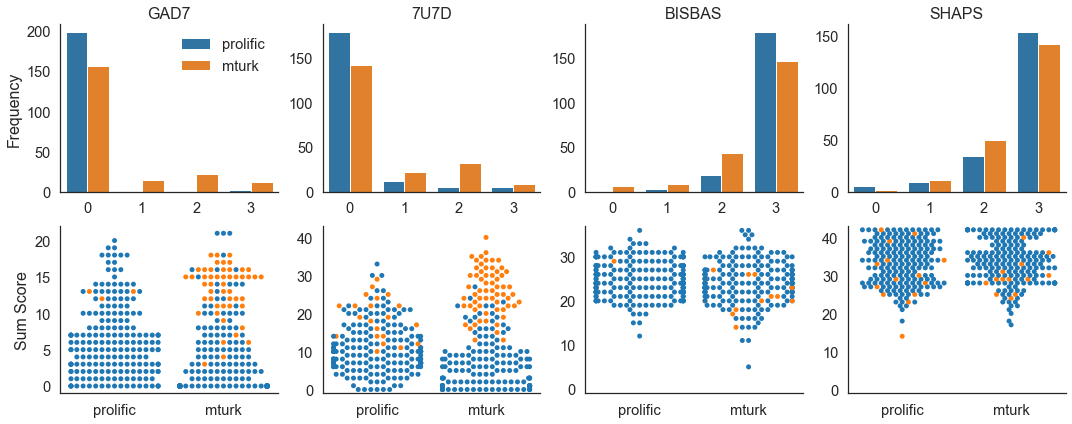

In [3]:
## Initialize canvas.
fig, axes = plt.subplots(2,4,figsize=(15,6))

## Define metadata.
prefixes = ['gad7','7u7d','bisbas','shaps']
orders = [np.arange(4), np.arange(4), np.arange(4), np.arange(4)] 
flags = [(1,2,3),(1,2,3),(0,1),(0,1)]

## Iteratively plot.
for i, (prefix, order, flag) in enumerate(zip(prefixes, orders, flags)):
    
    ## Extract survey.
    cols = ['platform','subject'] + surveys.filter(regex=f'{prefix}-q').columns.tolist()    
    items = surveys[cols].copy()
    
    ## Score infrequency item.
    items['infreq'] = np.in1d(items.values[:,-1], flag)
    reject[f'{prefix}-infreq'] = items['infreq'].values.astype(int)
    
    ## Compute sum scores.
    items['total'] = items[cols[2:-1]].sum(axis=1)
    
    ## Plot responses on infrequency items.
    sns.countplot(cols[-1], hue='platform', data=items, order=order, ax=axes[0,i])
    axes[0,i].legend_.set_visible(False)
    axes[0,i].set(xlabel='', ylabel='', title=prefix.upper())
        
    ## Plot distribution of scores.
    sns.swarmplot('platform', 'total', 'infreq', data=items,  ax=axes[1,i])
    axes[1,i].set(xlabel='', ylabel='', ylim=(-1, order[-1] * len(cols[2:-1]) + 1))
    axes[1,i].legend_.set_visible(False)
    
    ## Add details.
    if not i: 
        axes[0,i].legend(frameon=False, loc=1)
        axes[0,i].set_ylabel('Frequency')
        axes[1,i].set_ylabel('Sum Score')

sns.despine()
plt.tight_layout()

#### 1.2 Distributions after zero-tolerance exclusion

What would the distributions look like if we excluded participants who failed even a single check across questionnaires?

,sum,mean
platform,,
mturk,140,0.682927
prolific,42,0.208955


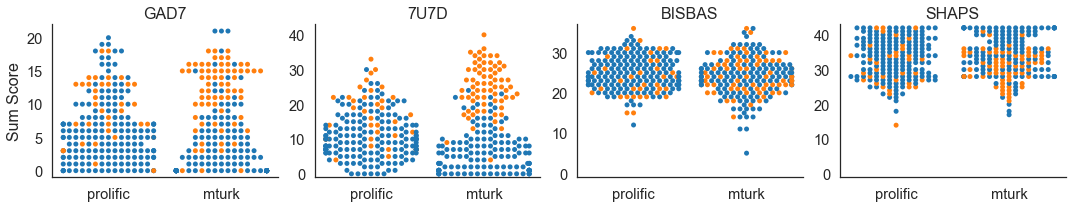

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(15,3))

## Compute total number of suspicious responses.
reject['infreq'] = reject[['gad7-infreq','7u7d-infreq','bisbas-infreq','shaps-infreq']].sum(axis=1)

## Threshold responses.
reject['infreq-any'] = (reject['infreq'] > 0).astype(int)

## Iteratively plot.
for i, (prefix, order, flag) in enumerate(zip(prefixes, orders, flags)):
    
    ## Extract survey.
    cols = ['platform','subject'] + surveys.filter(regex=f'{prefix}-q').columns.tolist()    
    items = surveys[cols].copy()
    
    ## Compute sum scores.
    items['total'] = items[cols[2:-1]].sum(axis=1)
    items = items.merge(reject[['platform','subject','infreq-any']])
        
    ## Plot distribution of scores.
    sns.swarmplot('platform', 'total', 'infreq-any', data=items,  ax=axes[i])

    axes[i].set(xlabel='', ylabel='', ylim=(-1, order[-1] * len(cols[2:-1]) + 1), title=prefix.upper())
    axes[i].legend_.set_visible(False)
    
    ## Add details.
    if not i: 
        axes[i].set_ylabel('Sum Score')
        
sns.despine()
plt.tight_layout()

reject.groupby('platform').infreq.agg(['sum','mean'])

#### 1.3 Similarity of Infrequency Items

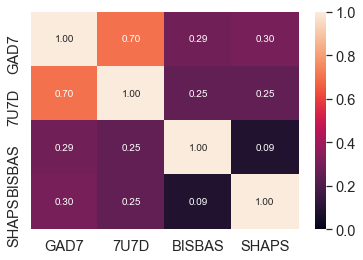

In [5]:
from pandas import DataFrame
from sklearn.metrics import pairwise_distances

## Extract infrequency items.
infreq = reject.filter(regex='-infreq').values.astype(bool)

## Compute Dice similarity.
cols = ['GAD7','7U7D','BISBAS','SHAPS']
dice = DataFrame(1 - pairwise_distances(infreq.T, metric='dice'), columns=cols, index=cols)

## Plot similarity
sns.heatmap(dice, vmin=0, vmax=1, annot=True, fmt='0.2f');

#### 1.4 Similarity of Infrequency Items under Random Noise

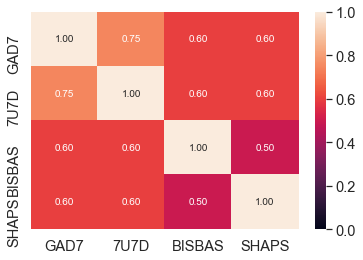

In [6]:
np.random.seed(47404)

## Define metadata.
flags = [(1,2,3),(1,2,3),(2,3),(2,3)]
n_sim = 1000

## Preallocate space.
D = np.zeros((n_sim,4,4))

## Iteratively simulate.
for i in range(n_sim):
    
    ## Simulate random responses.
    Y = np.row_stack([
        np.zeros((300,4)),
        np.random.randint(0,4,(100,4))
    ])
    
    ## Threshold according to actual scales.
    for j, flag in enumerate(flags):
        Y[:,j] = np.in1d(Y[:,j], flag)

    ## Compute and store similarity.
    D[i] = 1 - pairwise_distances(Y.T.astype(bool), metric='dice')
    
## Average across simulations.
D = DataFrame(D.mean(axis=0), columns=cols, index=cols)

## Plot similarity
sns.heatmap(D, vmin=0, vmax=1, annot=True, fmt='0.2f');

## Section 2: Survey Metrics

In [7]:
## Define subscales.
subscales = [
    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q12'],    # 7u7d Mania
    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q13','7u7d-q14'],    # 7u7d Depression
    ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],    # GAD-7
    ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08'],
    ['bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05','shaps-q06','shaps-q07',
     'shaps-q08','shaps-q09','shaps-q10','shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
    ['pswq-q01','pswq-q02','pswq-q03']
]
minlengths = [4,4,4,4,4,4,4,5]

#### 2.1 Entropy

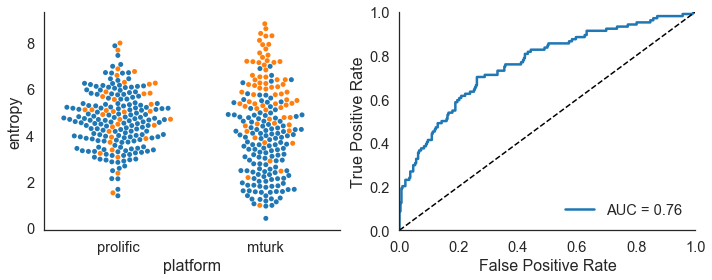

In [8]:
from scipy.stats import entropy

## Preallocate space.
scores = np.zeros((len(surveys), len(subscales)))

## Iteratively compute entropy.
for i, (cols, minlength) in enumerate(zip(subscales, minlengths)):
    
    ## Tally responses within subscale.
    p = np.row_stack(surveys[cols].apply(np.bincount, axis=1, minlength=minlength))
    
    ## Normalize within subject. 
    p = np.apply_along_axis(lambda x: x / x.sum(), 1, p)
    
    ## Compute entropy.
    scores[:,i] = np.apply_along_axis(entropy, 1, p)

## Store.
reject['entropy'] = scores.sum(axis=1)

## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], reject['entropy'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot('platform', 'entropy', 'infreq-any', data=reject, ax=axes[0])
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1], [0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

#### 2.2 Personal Reliability

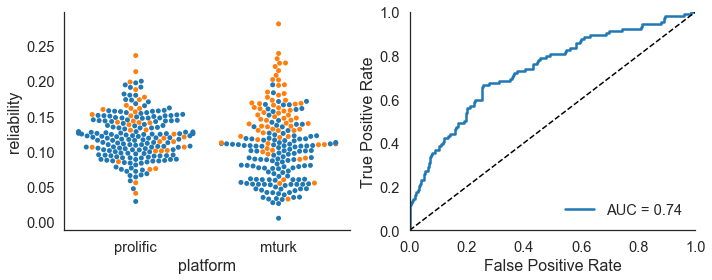

In [9]:
np.random.seed(47404)

## Define metadata.
n_iter = 1000

## Main loop.
split_half = np.zeros((n_iter, surveys.shape[0]), dtype=float)

for i in range(n_iter):
    
    ## Permute subscales.
    subscales = [np.random.permutation(subscale) for subscale in subscales]
    
    ## Iteratively compute split-half reliability.
    for subscale, minlength in zip(subscales, minlengths):
        
        ## Compute average within each half.
        mu_1 = surveys[subscale[::2]].mean(axis=1)
        mu_2 = surveys[subscale[1::2]].mean(axis=1)
        
        ## Compute reliability.
        split_half[i] += np.abs(mu_1 - mu_2) / (minlength - 1)
        
    ## Normalize.
    split_half[i] /= len(subscales)
    
## Average across permutations.
reject['reliability'] = split_half.mean(axis=0)

## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], reject['reliability'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot('platform', 'reliability', 'infreq-any', data=reject, ax=axes[0])
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1], [0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

#### 2.2 Mahalanobis D

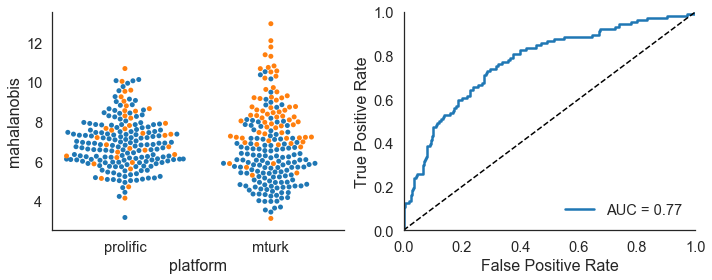

In [10]:
## Restrict to items of interest.
items = surveys[np.concatenate(subscales)].copy()

## Compute (inverse) covariance matrix.
Sigma = items.cov()
Sigma_inv = np.linalg.inv(Sigma)

## Preallocate space.
D = np.zeros(items.shape[0])

## Iteratively compute  Mahalanobis D.
mu = items.mean()
for i in range(items.shape[0]):
    x = items.iloc[i] - mu
    D[i] = np.sqrt(x @ Sigma_inv @ x)
    
## Store.
reject['mahalanobis'] = D
    
## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], reject['mahalanobis'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot('platform', 'mahalanobis', 'infreq-any', data=reject, ax=axes[0])
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1], [0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

#### 2.3 Reading Times 
Following Ophir et al. (2019), we set a a reading-speed threshold of 10 words per second. This amounts to approximately 1s per GAD-7 item (8s total), 2.5s per 7-up-7-down item (37.5s total), 1s per BIS/BAS item (13s total), and 1s per SHAPS items (15s total).



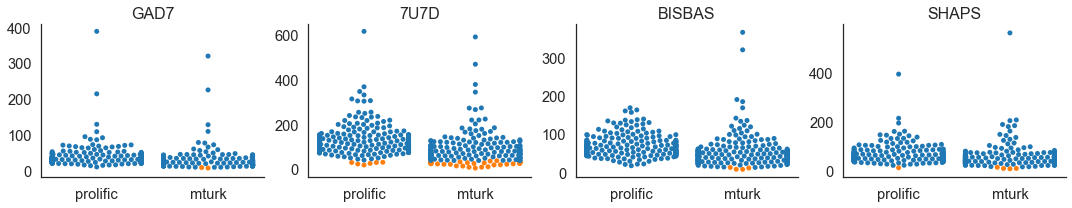

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(15,3))

## Define metadata.
prefixes = ['gad7','7u7d','bisbas','shaps']
orders = [np.arange(4), np.arange(4), np.arange(4), np.arange(4)] 
totals = [8, 37.5, 13, 15]

## Iteratively plot.
for i, (prefix, order, total) in enumerate(zip(prefixes, orders, totals)):
    
    ## Extract survey.
    cols = ['platform','subject'] + surveys.filter(regex=prefix).columns.tolist()    
    items = surveys[cols].copy()
    
    ## Score response times..
    items['rt'] = items.values[:,-1] < total
    reject[f'{prefix}-rt'] = items['rt'].values
    
    ## Plot responses on infrequency items.
    sns.swarmplot('platform', items[cols[-1]], 'rt', data=items, ax=axes[i])
    axes[i].legend_.set_visible(False)
    axes[i].set(xlabel='', ylabel='', title=prefix.upper())
    
## Compute total number of suspicious responses.
reject['reading'] = reject[['gad7-rt','7u7d-rt','bisbas-rt','shaps-rt']].sum(axis=1)
    
sns.despine()
plt.tight_layout()

## Section 3: Metadata Screens

In [12]:
## Load metadata.
prolific = read_csv(os.path.join(path_prolific,'metadata.csv'))
mturk = read_csv(os.path.join(path_mturk,'metadata.csv'))
metadata = concat([prolific, mturk], sort=False)

#### 3.1 Total Time

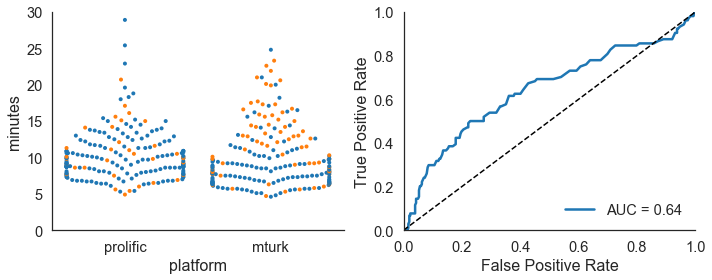

In [13]:
## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], metadata['minutes'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot(reject['platform'], metadata['minutes'], reject['infreq-any'], size=4, ax=axes[0])
axes[0].set(ylim=(0,30))
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1],[0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

#### 3.2 Instruction Loops

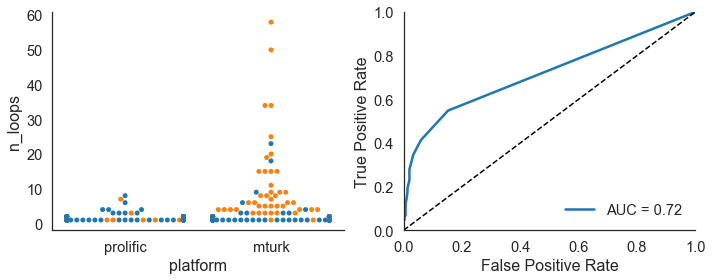

In [14]:
## Store.
reject['n_loops'] = metadata['n_loops'].copy()

## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], metadata['n_loops'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot(metadata.platform, metadata['n_loops'], hue=reject['infreq-any'], ax=axes[0])
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1], [0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

## Section 4: Behavioral Data

In [15]:
## Load survey data.
prolific = read_csv(os.path.join(path_prolific,'data.csv'))
mturk = read_csv(os.path.join(path_mturk,'data.csv'))
data = concat([prolific,mturk])

#### 4.1 Accuracy
```python
from scipy.stats import binom_test
binom_test(38, n=90, p=0.33, alternative='greater')
```

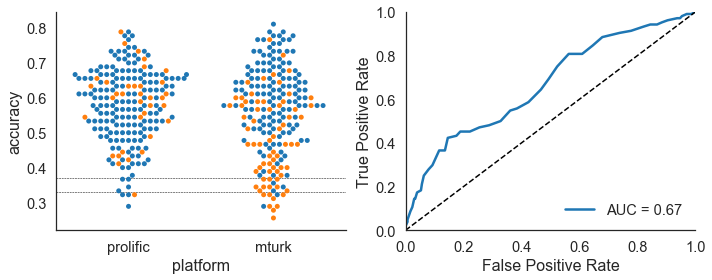

In [16]:
## Compute within-subject accuracy.
gb = data.groupby(['platform','subject']).accuracy.mean().reset_index()

## Merge with DataFrame.
reject = reject.merge(gb)

## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], 1-reject['accuracy'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot('platform', 'accuracy', 'infreq-any', data=reject, ax=axes[0])
axes[0].axhline(0.33, lw=0.5, linestyle='--', color='k')
axes[0].axhline(0.37, lw=0.5, linestyle='--', color='k')
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1], [0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

#### 4.2 Win-Stay Lose-Shift

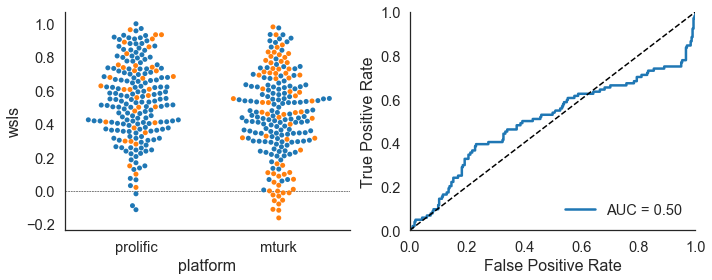

In [17]:
## Define WSLS regression.
def wsls_regression(df):
    df = df.dropna().copy()
    X = df[['intercept','prev_outcome']].dropna().values    
    y = df['stay']
    return np.linalg.lstsq(X,y,rcond=-1)[0][-1]

## Define previous outcome.
f = lambda x: np.roll(x, 1)
data['prev_outcome'] = data.groupby('subject').outcome.transform(f)
data.loc[data.trial==1,'prev_outcome'] = np.nan

## Define stay choices.
f = lambda x: (x == np.roll(x,1)).astype(int)
data['stay'] = data.groupby('subject').choice.transform(f)
data.loc[data.trial==1,'stay'] = np.nan

## Define intercept.
data['intercept'] = 1

## Compute pivot table.
pivot = data.groupby(['platform','subject','prev_outcome']).stay.mean().reset_index()
pivot = pivot.pivot_table('stay',['platform','subject'],'prev_outcome').reset_index()

## Compute WSLS coefficient.
coef = data.groupby(['platform','subject']).apply(wsls_regression).reset_index()
coef = coef.rename(columns={0:'wsls'})

## Merge with DataFrame.
reject = reject.merge(coef) 

## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], reject['wsls'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot('platform', 'wsls', 'infreq-any', data=reject, ax=axes[0])
axes[0].axhline(0, lw=0.5, linestyle='--', color='k')
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1], [0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

#### 4.3 Response Times

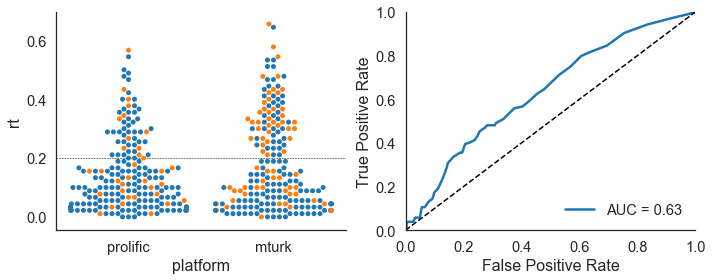

In [18]:
## Compute within-subject response time flags.
f = lambda x: np.logical_or(x < 0.1, x > 2.0).mean()
gb = data.groupby(['platform','subject']).rt.apply(f).reset_index()

## Merge with DataFrame.
reject = reject.merge(gb)

## Compute ROC.
fpr, tpr, thresh = roc_curve(reject['infreq-any'], reject['rt'])
auc_score = auc(fpr, tpr)

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(10,4))

## Plot completion time.
sns.swarmplot('platform', 'rt', 'infreq-any', data=reject, ax=axes[0])
axes[0].axhline(0.20, lw=0.5, linestyle='--', color='k')
axes[0].legend_.set_visible(False)

## Plot ROC.
axes[1].plot(fpr, tpr, lw=2.5, label='AUC = %0.2f' %auc_score)
axes[1].plot([0,1], [0,1], linestyle='--', color='k')
axes[1].set(xlim=(0,1), xlabel='False Positive Rate', ylim=(0,1), ylabel='True Positive Rate')
axes[1].legend(loc=4, frameon=False)

sns.despine()
plt.tight_layout()

## Section 5: Metric Correspondence

In [19]:
## Define columns of interest.
cols = ['infreq','entropy','reliability','mahalanobis','reading','accuracy','wsls','rt']

## Define sorting.
dd = dict(infreq=False, entropy=False, reliability=False, mahalanobis=False, 
          reading=False, accuracy=True, wsls=True, rt=False)

#### 5.1 Monotonic Dependence

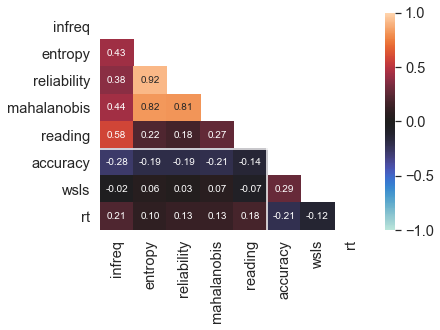

In [20]:
## Compute correlation matrix.
corr = reject[cols].corr(method='spearman').values
corr[np.triu_indices_from(corr, k=0)] = np.nan

## Plot.
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, fmt='0.2f',
                 xticklabels=cols, yticklabels=cols)
ax.hlines(5, 0, len(cols), color='w')
ax.vlines(5, 0, len(cols), color='w');

#### 5.2 Rejection Similarity (25%) 

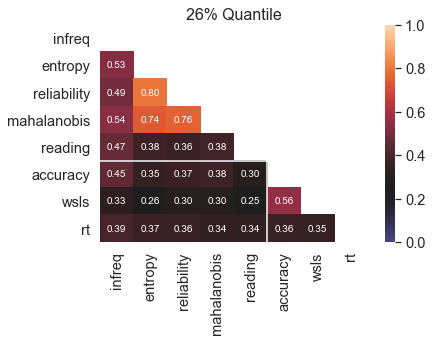

In [21]:
from scipy.spatial.distance import dice

## Make copy of DataFrame.
df = reject[['subject']+cols].copy().set_index('subject')

## Preallocate space.
corr = np.zeros((8, 8))

## Compute overlap w.r.t. infrequency.
n_sub = (df['infreq'] > 0).sum()
quantile = n_sub / df.shape[0]

for j in range(0,8):
    
    for i in range(j+1,8):
        
        ## Extract subjects.
        x = df[cols[i]].sort_values(ascending=dd[cols[i]]).index[:n_sub]
        y = df[cols[j]].sort_values(ascending=dd[cols[j]]).index[:n_sub]
        
        ## Compute agreement.
        corr[i,j] = 1-dice(np.in1d(df.index,x), np.in1d(df.index,y))

## Mask correlation matrix.
corr[np.triu_indices_from(corr, k=0)] = np.nan

## Plot.
ax = sns.heatmap(corr, vmin=0, vmax=1, center=quantile, annot=True, fmt='0.2f',
                 xticklabels=cols, yticklabels=cols)
ax.hlines(5, 0, len(cols), color='w')
ax.vlines(5, 0, len(cols), color='w');
ax.set_title('%0.0f%% Quantile' %(quantile * 100));

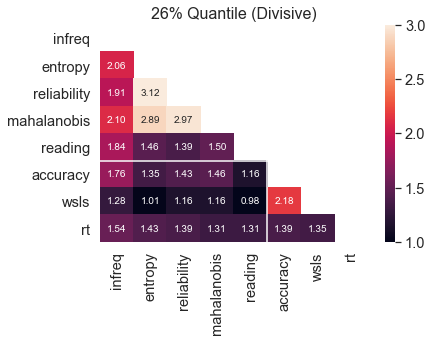

In [22]:
from scipy.spatial.distance import dice

## Make copy of DataFrame.
df = reject[['subject']+cols].copy().set_index('subject')

## Preallocate space.
corr = np.zeros((8, 8))

## Compute overlap w.r.t. infrequency.
n_sub = (df['infreq'] > 0).sum()
quantile = n_sub / df.shape[0]

for j in range(0,8):
    
    for i in range(j+1,8):
        
        ## Extract subjects.
        x = df[cols[i]].sort_values(ascending=dd[cols[i]]).index[:n_sub]
        y = df[cols[j]].sort_values(ascending=dd[cols[j]]).index[:n_sub]
        
        ## Compute agreement.
        corr[i,j] = 1-dice(np.in1d(df.index,x), np.in1d(df.index,y))

## Mask correlation matrix.
corr[np.triu_indices_from(corr, k=0)] = np.nan

## Plot.
ax = sns.heatmap(corr / quantile, vmin=1, vmax=3, annot=True, fmt='0.2f',
                 xticklabels=cols, yticklabels=cols)
ax.hlines(5, 0, len(cols), color='w')
ax.vlines(5, 0, len(cols), color='w');
ax.set_title('%0.0f%% Quantile (Divisive)' %(quantile * 100));

#### 5.3 Rejection Similarity (9%)

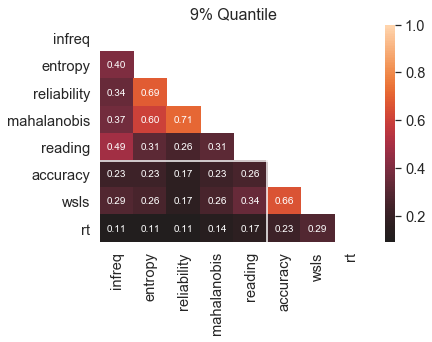

In [23]:
from scipy.spatial.distance import dice

## Make copy of DataFrame.
df = reject[['subject']+cols].copy().set_index('subject')

## Preallocate space.
corr = np.zeros((8, 8))

## Compute overlap w.r.t. infrequency.
n_sub = (df['accuracy'] < 0.38).sum()
quantile = n_sub / df.shape[0]

for j in range(0,8):
    
    for i in range(j+1,8):
        
        ## Extract subjects.
        x = df[cols[i]].sort_values(ascending=dd[cols[i]]).index[:n_sub]
        y = df[cols[j]].sort_values(ascending=dd[cols[j]]).index[:n_sub]
        
        ## Compute agreement.
        corr[i,j] = 1-dice(np.in1d(df.index,x), np.in1d(df.index,y))

## Mask correlation matrix.
corr[np.triu_indices_from(corr, k=0)] = np.nan

## Plot.
ax = sns.heatmap(corr, vmin=0.09, vmax=1, center=quantile, annot=True, fmt='0.2f',
                 xticklabels=cols, yticklabels=cols)
ax.hlines(5, 0, len(cols), color='w')
ax.vlines(5, 0, len(cols), color='w');
ax.set_title('%0.0f%% Quantile' %(quantile * 100));

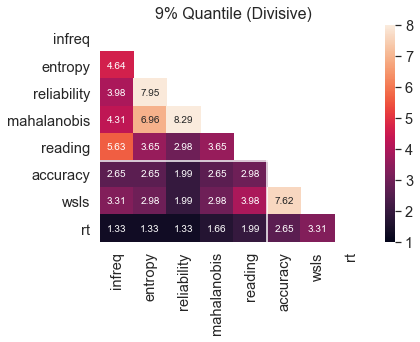

In [24]:
from scipy.spatial.distance import dice

## Make copy of DataFrame.
df = reject[['subject']+cols].copy().set_index('subject')

## Preallocate space.
corr = np.zeros((8, 8))

## Compute overlap w.r.t. infrequency.
n_sub = (df['accuracy'] < 0.38).sum()
quantile = n_sub / df.shape[0]

for j in range(0,8):
    
    for i in range(j+1,8):
        
        ## Extract subjects.
        x = df[cols[i]].sort_values(ascending=dd[cols[i]]).index[:n_sub]
        y = df[cols[j]].sort_values(ascending=dd[cols[j]]).index[:n_sub]
        
        ## Compute agreement.
        corr[i,j] = 1-dice(np.in1d(df.index,x), np.in1d(df.index,y))

## Mask correlation matrix.
corr[np.triu_indices_from(corr, k=0)] = np.nan

## Plot.
ax = sns.heatmap(corr / quantile, vmin=1, vmax=8, annot=True, fmt='0.2f',
                 xticklabels=cols, yticklabels=cols)
ax.hlines(5, 0, len(cols), color='w')
ax.vlines(5, 0, len(cols), color='w');
ax.set_title('%0.0f%% Quantile (Divisive)' %(quantile * 100));